In [23]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

public_works_violations_data = pd.read_csv('cleaned2_PUBLIC_WORKS_VIOLATIONS.csv')
building_property_violations_data = pd.read_csv('cleaned2_BUILDING_AND_PROPERTY_VIOLATIONS.csv')

public_works_violations_data['status_dttm'] = pd.to_datetime(public_works_violations_data['status_dttm'])
building_property_violations_data['status_dttm'] = pd.to_datetime(building_property_violations_data['status_dttm'])

public_works_violations_data = public_works_violations_data[public_works_violations_data['status_dttm'].dt.year == 2020]
building_property_violations_data = building_property_violations_data[building_property_violations_data['status_dttm'].dt.year == 2020]

neighborhood_boundaries = gpd.read_file('BPDA_Neighborhood_Boundaries.geojson')

def violations_to_geodf(violations_data):
    violations_data['geometry'] = violations_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    return gpd.GeoDataFrame(violations_data, geometry='geometry', crs="EPSG:4326")

public_works_violations_gdf = violations_to_geodf(public_works_violations_data)
building_property_violations_gdf = violations_to_geodf(building_property_violations_data)

public_works_joined = gpd.sjoin(public_works_violations_gdf, neighborhood_boundaries, how="inner", op='within')
building_property_joined = gpd.sjoin(building_property_violations_gdf, neighborhood_boundaries, how="inner", op='within')

public_works_counts = public_works_joined['name'].value_counts().reset_index()
public_works_counts.columns = ['name', 'public_works_violation_count']

building_property_counts = building_property_joined['name'].value_counts().reset_index()
building_property_counts.columns = ['name', 'building_property_violation_count']

combined_counts = pd.merge(public_works_counts, building_property_counts, on='name', how='outer')
combined_counts.fillna(0, inplace=True)

combined_counts['total_violation_count'] = combined_counts['public_works_violation_count'] + combined_counts['building_property_violation_count']

combined_counts.to_csv('Total_Violations_by_Neighborhood.csv', index=False)
print("Combined violation data for 2020 saved to 'Total_Violations_by_Neighborhood.csv'.")


Combined violation data for 2020 saved to 'Total_Violations_by_Neighborhood_2020.csv'.


D:\Anaconda3\envs\cs506\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
D:\Anaconda3\envs\cs506\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [24]:
import pandas as pd

# Load the datasets
demographic_data = pd.read_csv('demographic.csv')
violations_data = pd.read_csv('Total_Violations_by_Neighborhood.csv')

# Assuming 'field concept' and 'Total:' are correct column names for neighborhood and population
population_dict = pd.Series(demographic_data['Total:'].values, index=demographic_data['field concept']).to_dict()

# Assuming 'name' is the correct column name for neighborhood in the violations data
violations_data['population'] = violations_data['name'].map(population_dict)

# Save the updated data
violations_data.to_csv('Updated_Violations_with_Population.csv', index=False)

# Print the first few rows to check the results
print(violations_data.head())


          name  public_works_violation_count  \
0   Dorchester                         189.0   
1      Roxbury                         117.0   
2  East Boston                          52.0   
3  Beacon Hill                          46.0   
4    Hyde Park                          45.0   

   building_property_violation_count  total_violation_count  population  
0                               7895                 8084.0    122191.0  
1                               4445                 4562.0     54533.0  
2                               2284                 2336.0     43066.0  
3                               1431                 1477.0      9336.0  
4                               1650                 1695.0     34172.0  


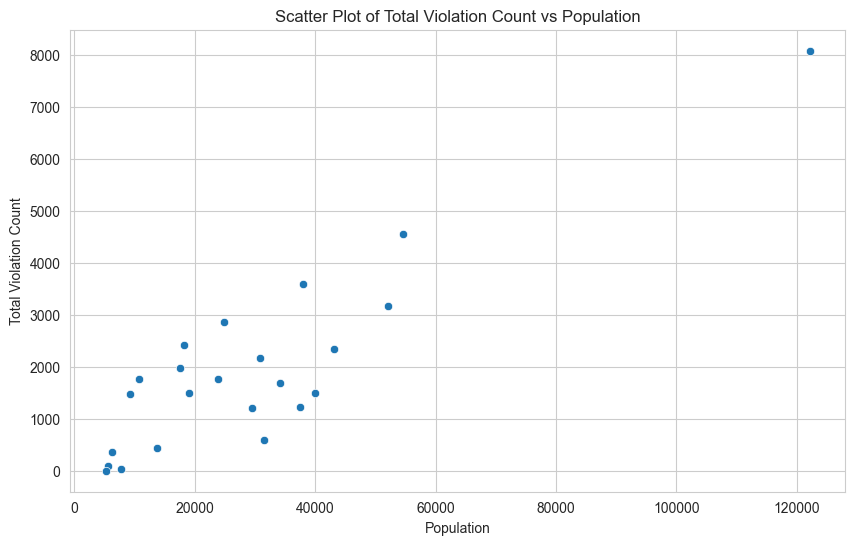

Pearson Correlation Coefficient: 0.8891623242555817
P-value: 1.4185666166955134e-08
Slope: 0.06304212357091088
Intercept: 95.07731894281619
R-squared: 0.7906096388755879


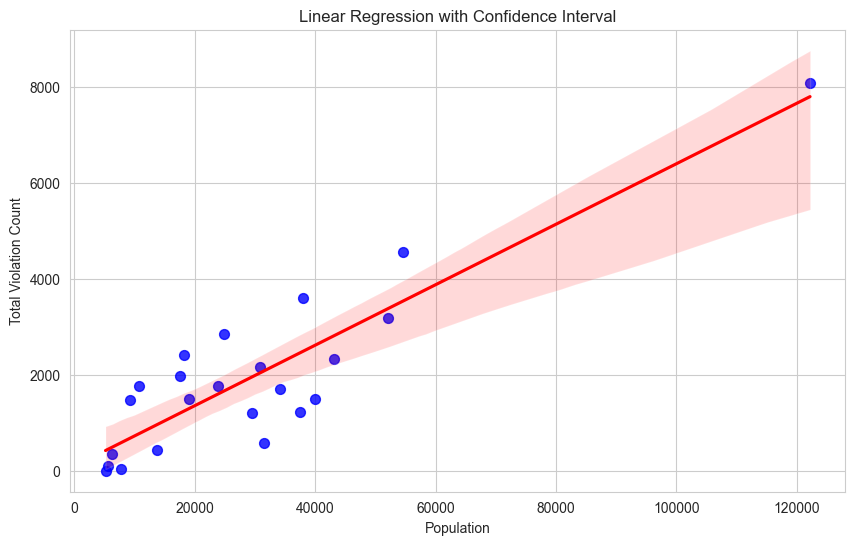

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np

file_path = 'Updated_Violations_with_Population.csv'
data = pd.read_csv(file_path)

desc_stats = data[['total_violation_count', 'population']].describe()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='population', y='total_violation_count', data=data)
plt.title('Scatter Plot of Total Violation Count vs Population')
plt.xlabel('Population')
plt.ylabel('Total Violation Count')

plt.grid(True)
plt.show()


# Pearson
corr_coefficient, p_value = pearsonr(data.dropna()['population'], data.dropna()['total_violation_count'])
print("Pearson Correlation Coefficient:", corr_coefficient)
print("P-value:", p_value)

# Linear Regression
X = data.dropna()['population'].values.reshape(-1, 1)
y = data.dropna()['total_violation_count'].values
model = LinearRegression()
model.fit(X, y)

# Plot the regression line
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X, y)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_squared)

plt.figure(figsize=(10, 6))
sns.regplot(x='population', y='total_violation_count', data=data,
            ci=95,
            color='gray',
            line_kws={'color': 'red'},
            scatter_kws={'s': 50, 'color': 'blue'})

plt.title('Linear Regression with Confidence Interval')
plt.xlabel('Population')
plt.ylabel('Total Violation Count')
plt.grid(True)
plt.show()



Dorchester


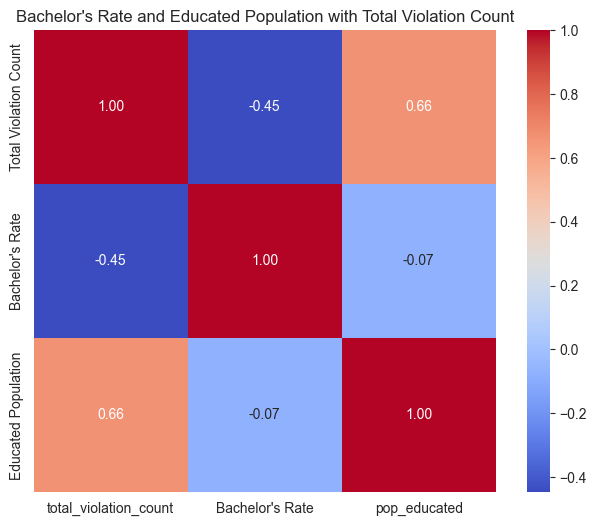

Descriptive Statistics:
        public_works_violation_count  building_property_violation_count  \
count                     23.000000                          23.000000   
mean                      31.565217                        1915.434783   
std                       42.888678                        1738.042651   
min                        0.000000                           1.000000   
25%                        5.500000                         870.500000   
50%                       20.000000                        1650.000000   
75%                       38.000000                        2335.500000   
max                      189.000000                        7895.000000   

       total_violation_count     population  Rate_2020  
count              23.000000      23.000000  23.000000  
mean             1947.000000   29375.956522  61.495652  
std              1775.762167   25045.806297  21.546366  
min                 1.000000    5186.000000  20.100000  
25%               892.0

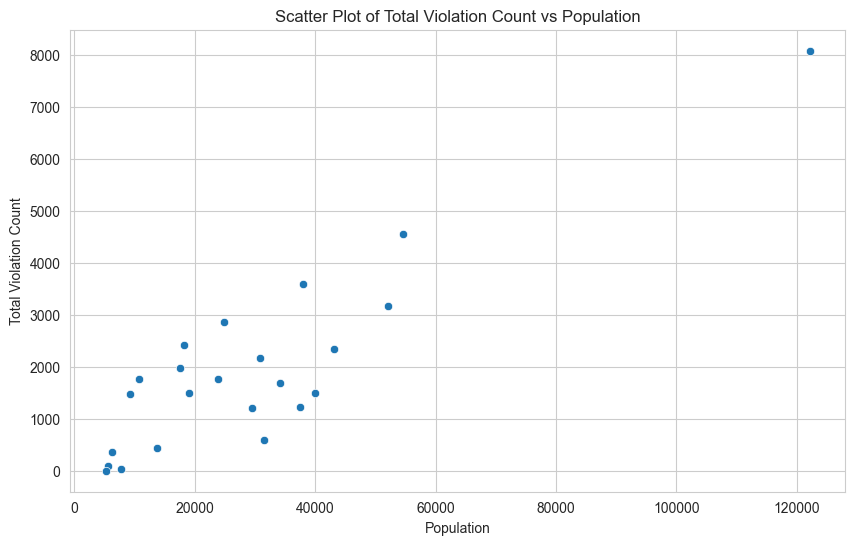

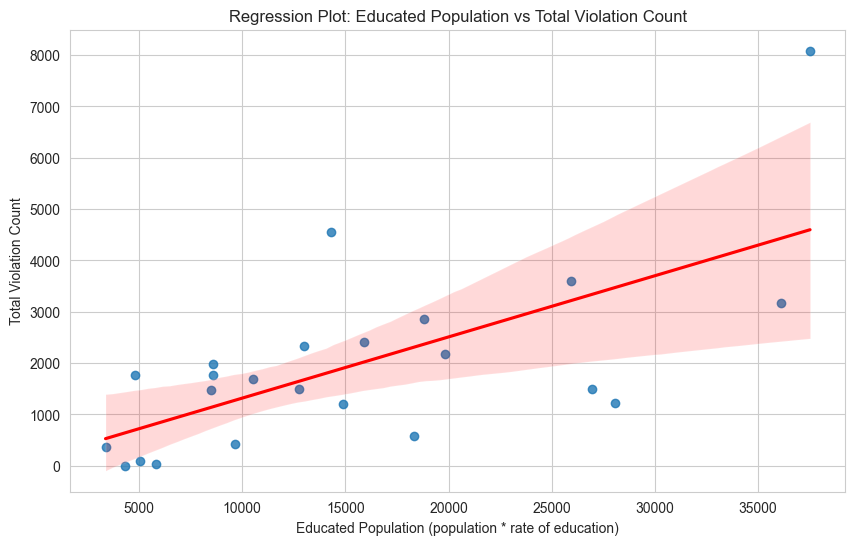

In [23]:
import pandas as pd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load violations and population data
violations_path = 'Updated_Violations_with_Population.csv'
violations_data = pd.read_csv(violations_path)

# Load education rate data
education_path = 'Boston_Neighborhood_Education_Rate_2020.csv'
education_data = pd.read_csv(education_path)

# Merge datasets on the neighborhood name
combined_data = pd.merge(violations_data, education_data, left_on='name', right_on='Neighborhood', how='inner')
combined_data.drop(columns=['Neighborhood'], inplace=True)

# Descriptive statistics
desc_stats_combined = combined_data.describe()

# Pearson correlation coefficients
corr_matrix = combined_data[['population', 'Rate_2020', 'total_violation_count']].corr()

# Multivariate linear regression
X_multi = combined_data[['population', 'Rate_2020']]
y_multi = combined_data['total_violation_count']
model_multi = LinearRegression()
model_multi.fit(X_multi, y_multi)

# Regression coefficients and R-squared value
coefficients_multi = model_multi.coef_
intercept_multi = model_multi.intercept_
r_squared_multi = model_multi.score(X_multi, y_multi)

# New feature: population times education rate
combined_data['pop_educated'] = combined_data['population'] * combined_data['Rate_2020'] / 100
# print the max value of the new feature and its neighborhood
print(combined_data.loc[combined_data['pop_educated'].idxmax()]['name'])

# Pearson correlation coefficient for the new feature with total violation count
corr_pop_educated, p_value_pop_educated = pearsonr(combined_data['pop_educated'], combined_data['total_violation_count'])

# Plotting the heatmap for selected correlations
selected_corr = combined_data[['total_violation_count', 'Rate_2020', 'pop_educated']].corr()
selected_corr.rename(columns={'Rate_2020': "Bachelor's Rate"}, inplace=True)
selected_corr.index = ['Total Violation Count', "Bachelor's Rate", 'Educated Population']

plt.figure(figsize=(8, 6))
sns.heatmap(selected_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Bachelor's Rate and Educated Population with Total Violation Count")
plt.show()

# Print the statistics
print("Descriptive Statistics:\n", desc_stats_combined)
print("\nCorrelation Matrix:\n", corr_matrix)
print("\nMultivariate Linear Regression Coefficients:", coefficients_multi)
print("Intercept:", intercept_multi)
print("R-squared Value:", r_squared_multi)
print("\nPopulation Educated Pearson Correlation Coefficient:", corr_pop_educated)
print("P-value:", p_value_pop_educated)

# Scatter plot of Total Violation Count vs Population
plt.figure(figsize=(10, 6))
sns.scatterplot(x='population', y='total_violation_count', data=combined_data)
plt.title('Scatter Plot of Total Violation Count vs Population')
plt.xlabel('Population')
plt.ylabel('Total Violation Count')
plt.grid(True)
plt.show()

# Plotting the relationship between 'pop_educated' and 'total_violation_count' with a regression line and confidence interval
plt.figure(figsize=(10, 6))
sns.regplot(x='pop_educated', y='total_violation_count', data=combined_data, ci=95, line_kws={'color': 'red'})
plt.title('Regression Plot: Educated Population vs Total Violation Count')
plt.xlabel('Educated Population (population * rate of education)')
plt.ylabel('Total Violation Count')
plt.grid(True)
plt.show()


C:\Users\23798\AppData\Local\Temp\ipykernel_16536\513929504.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='violation_per_educated_person', y='name', data=sorted_data, palette='Blues_d')


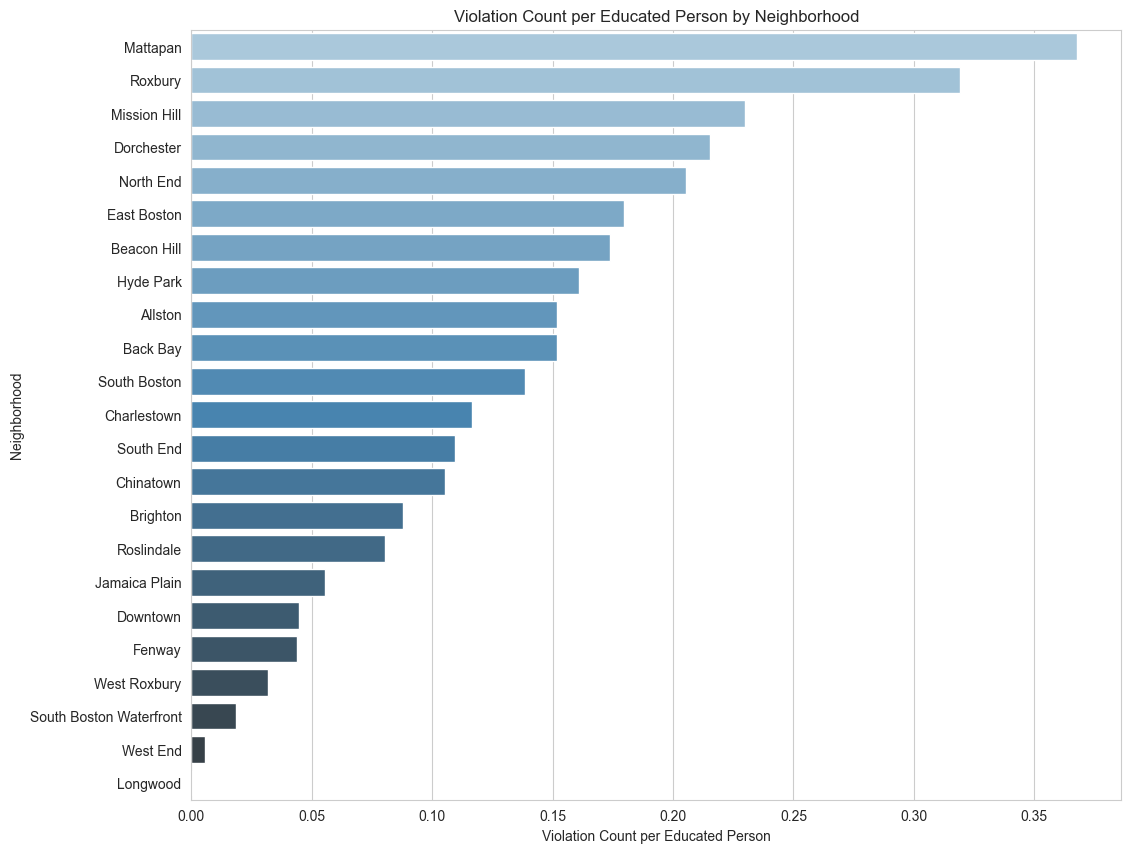

C:\Users\23798\AppData\Local\Temp\ipykernel_16536\513929504.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Rate_2020', y='name', data=sorted_data_by_education, palette='Blues_d')


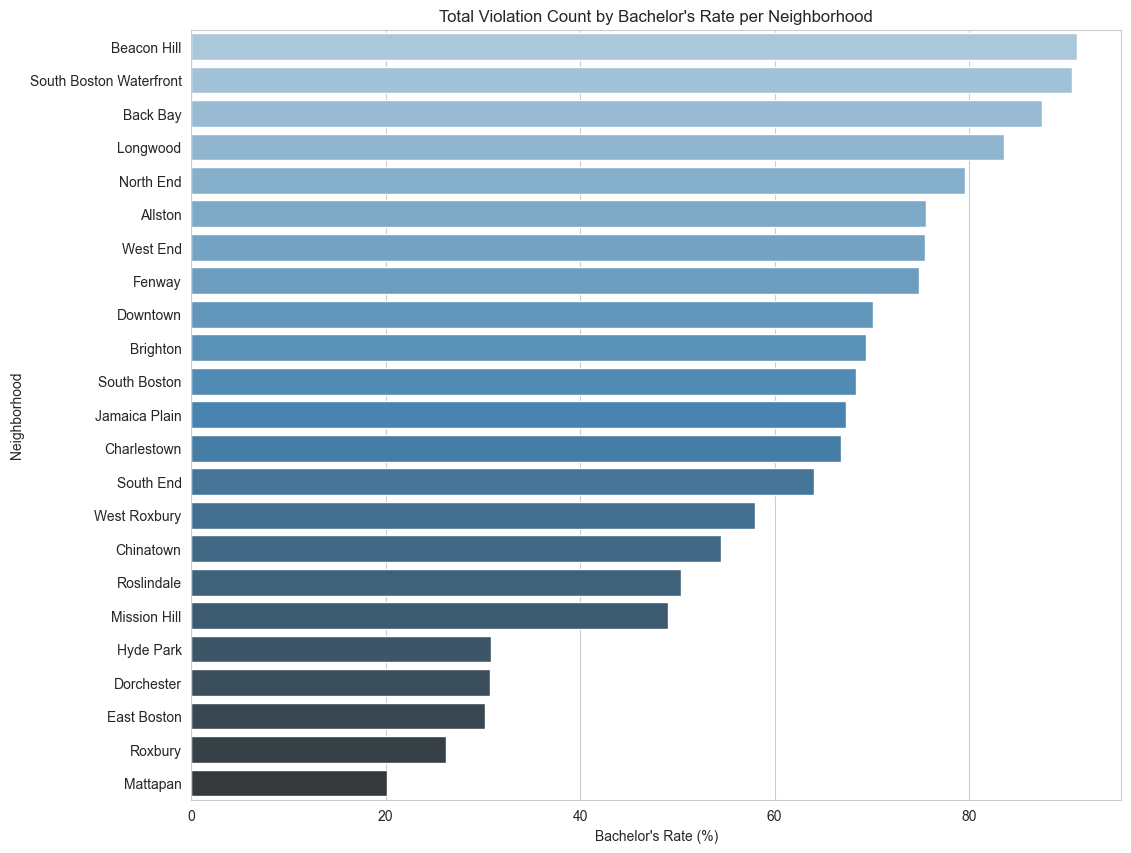

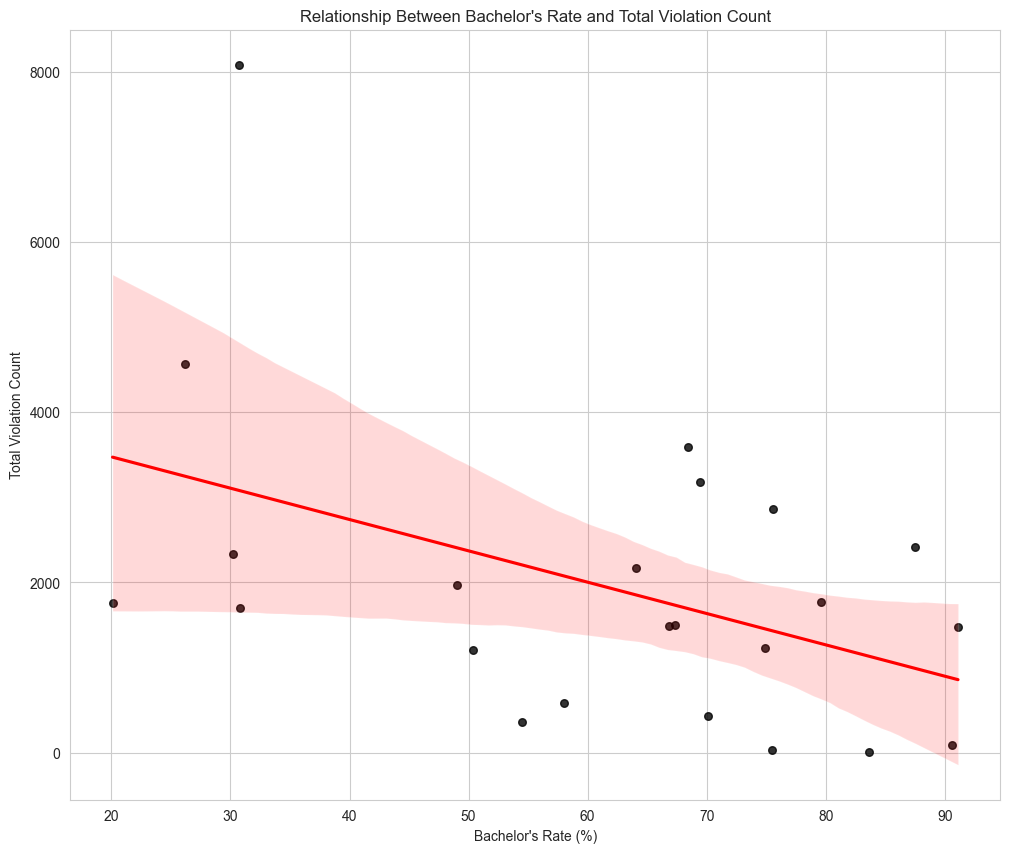

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate the ratio of total violation count to the educated population
combined_data['violation_per_educated_person'] = combined_data['total_violation_count'] / combined_data['pop_educated']

# Replace infinity with NaN and drop those rows
combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_data.dropna(subset=['violation_per_educated_person'], inplace=True)

# Sort the data by the new ratio column
sorted_data = combined_data.sort_values('violation_per_educated_person', ascending=False)

# Plotting the results
plt.figure(figsize=(12, 10))
sns.barplot(x='violation_per_educated_person', y='name', data=sorted_data, palette='Blues_d')
plt.title('Violation Count per Educated Person by Neighborhood')
plt.xlabel('Violation Count per Educated Person')
plt.ylabel('Neighborhood')
plt.show()

sorted_data_by_education = combined_data.sort_values('Rate_2020', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Rate_2020', y='name', data=sorted_data_by_education, palette='Blues_d')
plt.title('Total Violation Count by Bachelor\'s Rate per Neighborhood')
plt.xlabel('Bachelor\'s Rate (%)')
plt.ylabel('Neighborhood')
plt.show()

plt.figure(figsize=(12, 10))
sns.regplot(x='Rate_2020', y='total_violation_count', data=combined_data, ci=95,
            scatter_kws={"color": "black", "s": 30},
            line_kws={"color": "red"},
            color='gray')
plt.title('Relationship Between Bachelor\'s Rate and Total Violation Count')
plt.xlabel('Bachelor\'s Rate (%)')
plt.ylabel('Total Violation Count')
plt.grid(True)
plt.show()


                       name  population  total_violation_count  \
10                North End     10805.0                 1765.0   
3               Beacon Hill      9336.0                 1477.0   
8                  Back Bay     18190.0                 2415.0   
16                  Allston     24904.0                 2860.0   
17             Mission Hill     17518.0                 1973.0   
5              South Boston     37917.0                 3591.0   
1                   Roxbury     54533.0                 4562.0   
13              Charlestown     19120.0                 1490.0   
6                  Mattapan     23840.0                 1762.0   
7                 South End     30904.0                 2171.0   
0                Dorchester    122191.0                 8084.0   
12                 Brighton     52047.0                 3175.0   
20                Chinatown      6211.0                  356.0   
2               East Boston     43066.0                 2336.0   
4         

C:\Users\23798\AppData\Local\Temp\ipykernel_16536\2829593786.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='violation_to_population_ratio', y='name', data=sorted_data, palette='Blues_d')


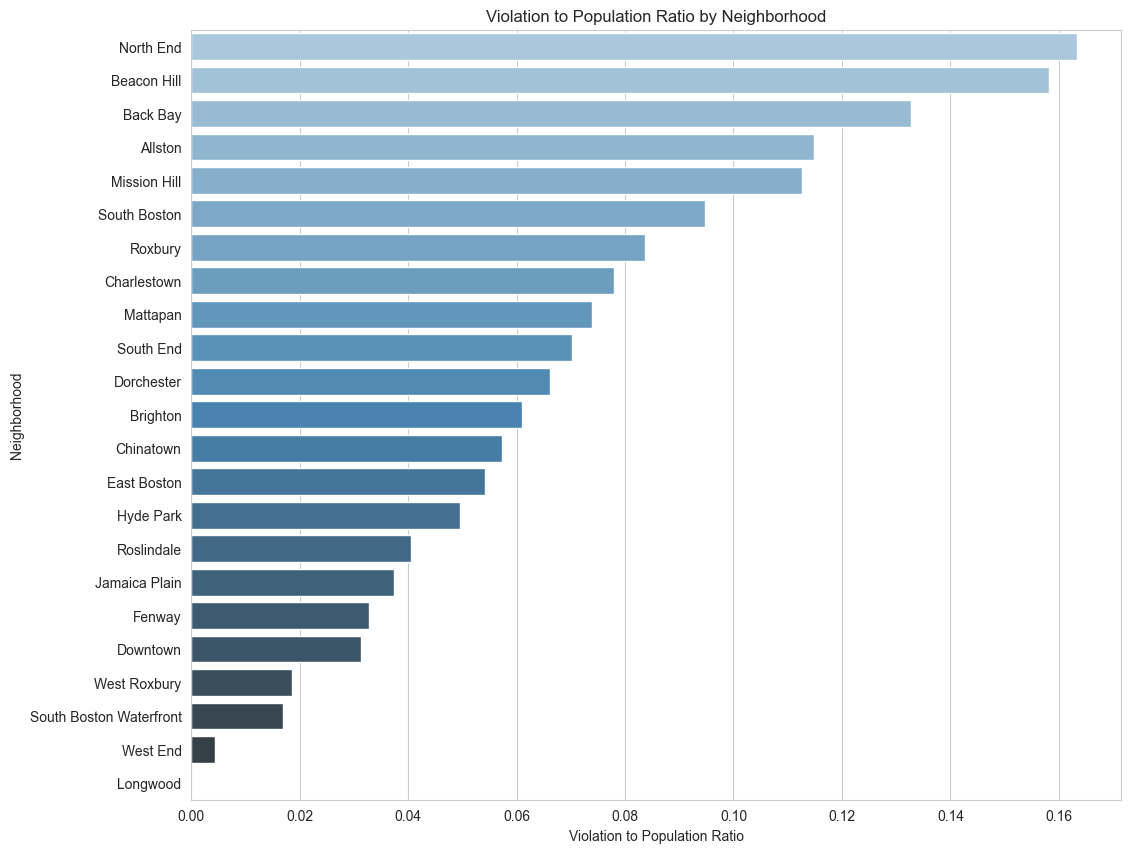

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

combined_data['violation_to_population_ratio'] = combined_data['total_violation_count'] / combined_data['population']

combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_data.dropna(subset=['violation_to_population_ratio'], inplace=True)

sorted_data = combined_data.sort_values(by='violation_to_population_ratio', ascending=False)

print(sorted_data[['name', 'population', 'total_violation_count', 'violation_to_population_ratio']])

plt.figure(figsize=(12, 10))
sns.barplot(x='violation_to_population_ratio', y='name', data=sorted_data, palette='Blues_d')
plt.title('Violation to Population Ratio by Neighborhood')
plt.xlabel('Violation to Population Ratio')
plt.ylabel('Neighborhood')
plt.show()


In [13]:
import pandas as pd

data_path = 'PUBLIC_WORKS_VIOLATIONS.csv'
data = pd.read_csv(data_path)

data_cleaned = data.drop(columns=['case_no', 'ap_case_defn_key', 'status', 'value'])

output_path = 'cleaned2_PUBLIC_WORKS_VIOLATIONS.csv'
data_cleaned.to_csv(output_path, index=False)

print("Data cleaned and saved successfully.")


Data cleaned and saved successfully.


In [14]:
import pandas as pd

data_path = 'BUILDING_AND_PROPERTY_VIOLATIONS.csv'
data = pd.read_csv(data_path)

data_cleaned = data.drop(columns=['case_no', 'ticket_no', 'status', 'value', 'code'])

output_path = 'cleaned2_BUILDING_AND_PROPERTY_VIOLATIONS.csv'
data_cleaned.to_csv(output_path, index=False)

print("Data cleaned and saved successfully.")

Data cleaned and saved successfully.


In [19]:
import geopandas as gpd
import pandas as pd

data_path = 'cleaned2_PUBLIC_WORKS_VIOLATIONS.csv'
data = pd.read_csv(data_path)

gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data.longitude, data.latitude),
    crs="EPSG:4326"
)

boundaries_path = 'BPDA_Neighborhood_Boundaries.geojson'
neighborhood_boundaries = gpd.read_file(boundaries_path)

gdf = gpd.sjoin(gdf, neighborhood_boundaries, how="left", op='within')

gdf.rename(columns={'name': 'Neighborhood'}, inplace=True)

gdf.drop(columns=['index_right'], inplace=True)

output_path = 'updated_PUBLIC_WORKS_VIOLATIONS.csv'
gdf.to_csv(output_path, index=False)

print("Data processed and saved successfully.")


D:\Anaconda3\envs\cs506\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Data processed and saved successfully.


In [20]:
import geopandas as gpd
import pandas as pd

data_path = 'cleaned2_BUILDING_AND_PROPERTY_VIOLATIONS.csv'
data = pd.read_csv(data_path)

gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data.longitude, data.latitude),
    crs="EPSG:4326"
)

boundaries_path = 'BPDA_Neighborhood_Boundaries.geojson'
neighborhood_boundaries = gpd.read_file(boundaries_path)

gdf = gpd.sjoin(gdf, neighborhood_boundaries, how="left", op='within')

gdf.rename(columns={'name': 'Neighborhood'}, inplace=True)

gdf.drop(columns=['index_right'], inplace=True)

output_path = 'updated_BUILDING_AND_PROPERTY_VIOLATIONS.csv'
gdf.to_csv(output_path, index=False)

print("Data processed and saved successfully.")


D:\Anaconda3\envs\cs506\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Data processed and saved successfully.


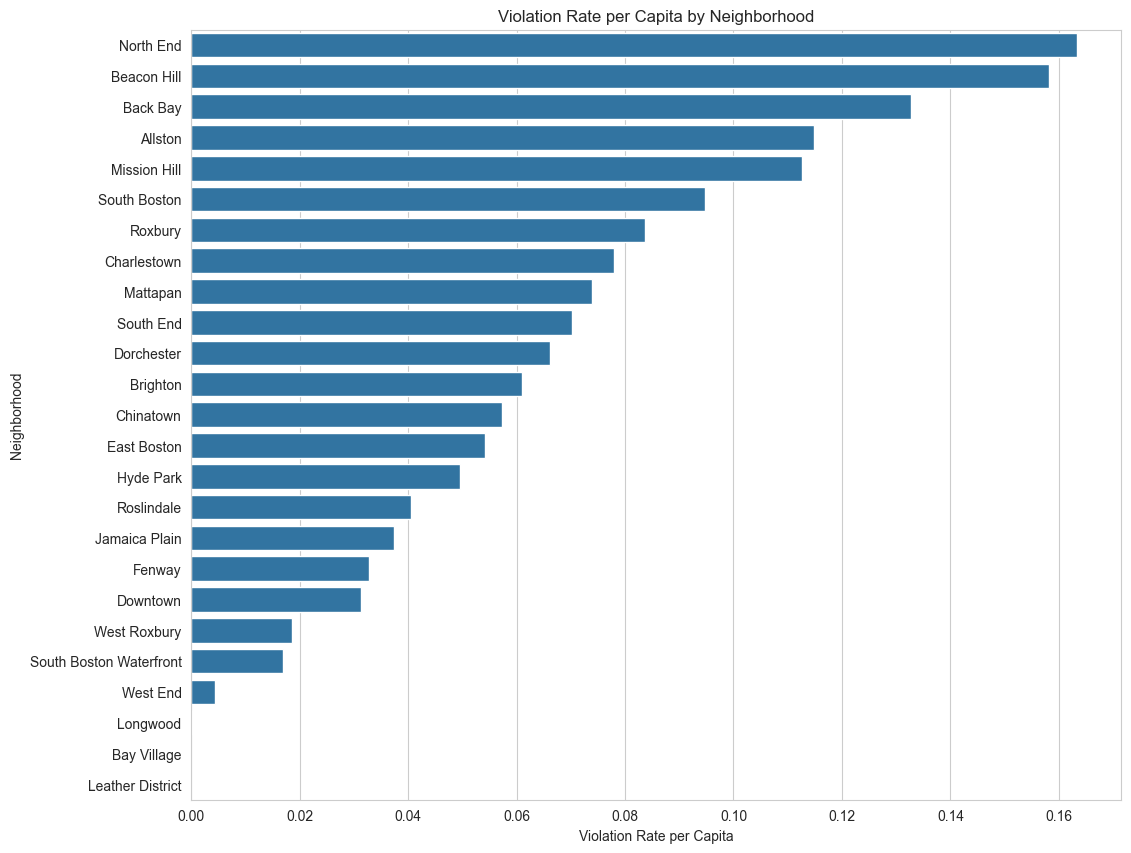

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load the data
data = pd.read_csv('Updated_Violations_with_Population.csv')

# calculate the violation rate per capita
data['Violation_Rate'] = data['total_violation_count'] / data['population']

# sort the data by violation rate
sorted_data = data.sort_values(by='Violation_Rate', ascending=False)

sns.set_style("whitegrid")

plt.figure(figsize=(12, 10))
sns.barplot(x='Violation_Rate', y='name', data=sorted_data)
plt.title('Violation Rate per Capita by Neighborhood')
plt.xlabel('Violation Rate per Capita')
plt.ylabel('Neighborhood')
plt.show()


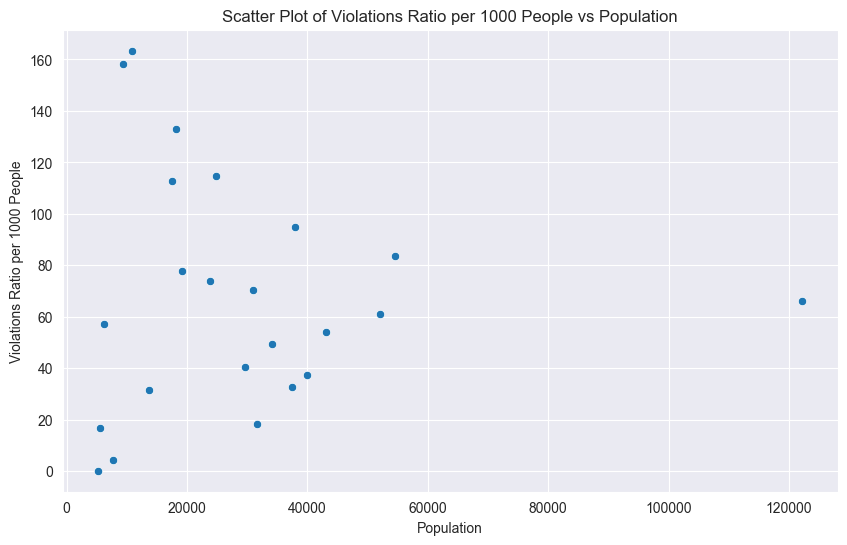

Pearson Correlation Coefficient: -0.03295763351137887
P-value: 0.8813288222478336
Slope: -5.977139297779914e-05
Intercept: 69.25539576419844
R-squared: 0.0010862056066701653


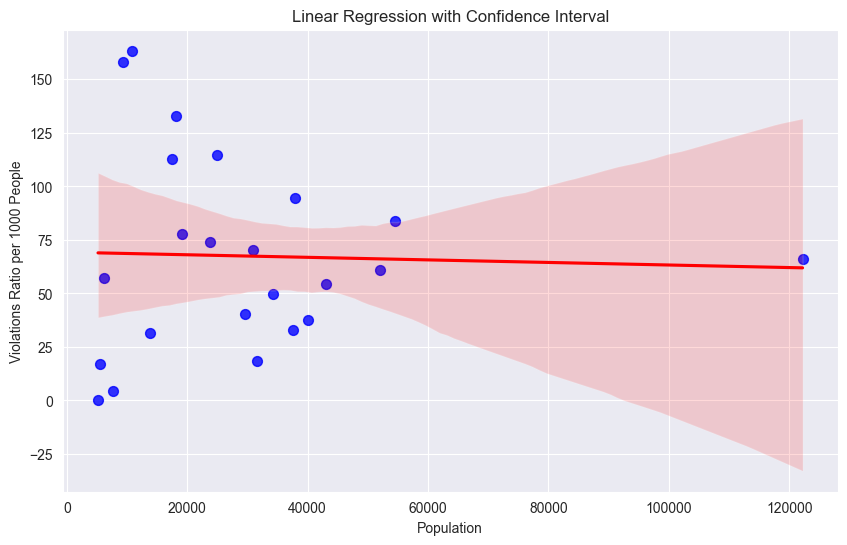

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

file_path = 'Updated_Violations_with_Population.csv'
data = pd.read_csv(file_path)

# 计算每个街区每1000人的违规数量与总违规数量之间的比率
data['violations_ratio_per_1000'] = (data['total_violation_count'] / data['population']) * 1000

desc_stats = data[['violations_ratio_per_1000', 'population']].describe()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='population', y='violations_ratio_per_1000', data=data)
plt.title('Scatter Plot of Violations Ratio per 1000 People vs Population')
plt.xlabel('Population')
plt.ylabel('Violations Ratio per 1000 People')
plt.grid(True)
plt.show()

# Pearson相关系数
corr_coefficient, p_value = pearsonr(data.dropna()['population'], data.dropna()['violations_ratio_per_1000'])
print("Pearson Correlation Coefficient:", corr_coefficient)
print("P-value:", p_value)

# 线性回归
X = data.dropna()['population'].values.reshape(-1, 1)
y = data.dropna()['violations_ratio_per_1000'].values
model = LinearRegression()
model.fit(X, y)

# 绘制回归线
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X, y)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_squared)

plt.figure(figsize=(10, 6))
sns.regplot(x='population', y='violations_ratio_per_1000', data=data,
            ci=95,
            color='gray',
            line_kws={'color': 'red'},
            scatter_kws={'s': 50, 'color': 'blue'})

plt.title('Linear Regression with Confidence Interval')
plt.xlabel('Population')
plt.ylabel('Violations Ratio per 1000 People')
plt.grid(True)
plt.show()
